In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['TSLA','FB','AMZN','GOOG','TWTR']**

In [2]:
import yfinance as yf
stock_symbol = 'TSLA'
data = yf.download(tickers=stock_symbol,period='4y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
1004,2022-05-23,655.020020,679.960022,638.059998,674.900024,674.900024,29634500
1005,2022-05-24,653.530029,653.919983,620.570007,628.159973,628.159973,29697500
1006,2022-05-25,623.849976,669.320007,623.010010,658.799988,658.799988,30713100
1007,2022-05-26,661.419983,718.669983,653.659973,707.729980,707.729980,35334400
1008,2022-05-27,723.250000,759.799988,720.530029,759.630005,759.630005,29630300


#### Visualizing the Real Stock Trend

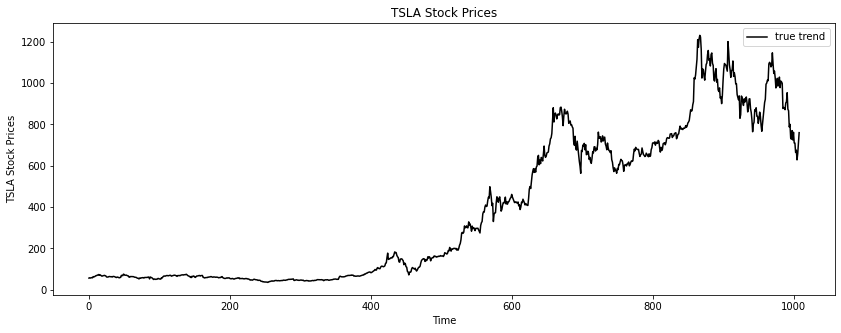

In [3]:
plt.figure(figsize=(14,5))
plt.plot(data['Close'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [4]:
test_size = 250
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((1009, 7), (759, 7), (250, 7))

#### Preparing the training data

In [5]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,55.702000,57.299999,55.230000,56.751999,28333000
1,56.658001,59.001999,56.320000,58.344002,37448500
2,57.442001,58.074001,56.585999,56.945999,29598500
3,57.172001,58.389999,56.768002,58.363998,27122000
4,58.868000,59.799999,58.709999,59.348000,23989000


In [6]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.0227817 , 0.02313154, 0.02371676, 0.02473516, 0.05474303])

In [7]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,3])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape

((509, 250, 5), (509,))

#### Preparaing testing data

In [8]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((500, 5),
            Open        High         Low       Close    Volume
 509  175.567993  177.304001  173.240005  177.132004  39059500
 510  183.800003  190.000000  181.832001  189.983994  70873500
 511  188.001999  190.888000  184.785995  188.134003  56941000
 512  198.376007  205.496002  196.500000  205.009995  92817000
 513  198.039993  203.792007  194.399994  194.567993  79582500)

In [9]:
df = scaler.transform(df)
df[0]

array([0.16294961, 0.16217569, 0.16484296, 0.16681065, 0.09143163])

In [10]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,3])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((250, 250, 5), (250,))

#### Defining the Scaling Label

In [11]:
# below is the scaling label, which will help inverse the transformation back to it's original values 
data_close = data.Close
data_close = data_close.values.reshape(-1, 1)
scaler_close = MinMaxScaler()
data_close_scaled = scaler_close.fit_transform(data_close)

In [12]:
y_test = y_test.reshape(-1,1)
y_test = scaler_close.inverse_transform(y_test)

#### GRU - Gated Recurrent Unit

In [13]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [14]:
x_train.shape[1],x_train.shape[2]

(250, 5)

In [15]:
model = Sequential()

# Input layer
model.add(GRU(units=40,activation='relu',return_sequences=False, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.5))

# output layer
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40)                5640      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 5,681
Trainable params: 5,681
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [17]:
def forecast():
    model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return y_pred

In [18]:
result_forecast = forecast()

Epoch 1/300
16/16 [==============================] - 7s 247ms/step - loss: 0.1311 - accuracy: 0.0039
Epoch 2/300
16/16 [==============================] - 4s 228ms/step - loss: 0.0362 - accuracy: 0.0039
Epoch 3/300
16/16 [==============================] - 4s 227ms/step - loss: 0.0275 - accuracy: 0.0039
Epoch 4/300
16/16 [==============================] - 4s 231ms/step - loss: 0.0200 - accuracy: 0.0039
Epoch 5/300
16/16 [==============================] - 4s 244ms/step - loss: 0.0219 - accuracy: 0.0039
Epoch 6/300
16/16 [==============================] - 4s 239ms/step - loss: 0.0219 - accuracy: 0.0039
Epoch 7/300
16/16 [==============================] - 4s 250ms/step - loss: 0.0187 - accuracy: 0.0039
Epoch 8/300
16/16 [==============================] - 4s 247ms/step - loss: 0.0166 - accuracy: 0.0039
Epoch 9/300
16/16 [==============================] - 4s 253ms/step - loss: 0.0164 - accuracy: 0.0039
Epoch 10/300
16/16 [==============================] - 4s 248ms/step - loss: 0.0131 - accura

#### Calculating the Accuracy using MAPE and RMSE

In [19]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100

mape_accuracy = calculate_accuracy(y_test, result_forecast)
mape_accuracy

93.23444047129583

#### Visualization

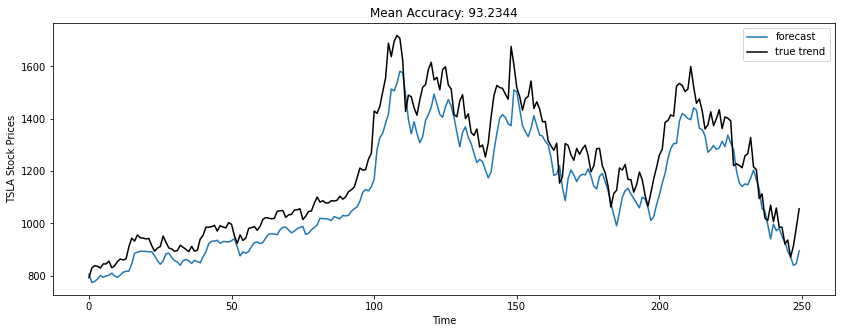

In [20]:
plt.figure(figsize=(14,5))
plt.plot(result_forecast,label='forecast')
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mape_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [24]:
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [25]:
short_window = int(0.025 * len(result_forecast))
long_window = int(0.05 * len(result_forecast))

signals = pd.DataFrame(index=range(test_size))
signals['signal'] = 0.0
signals['trend'] = result_forecast
signals['short_ma'] = signals.trend.rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = signals.trend.rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,trend,short_ma,long_ma,positions
0,0.0,805.754578,805.754578,805.754578,NaN
1,0.0,774.203003,789.978790,789.978790,0.0
2,0.0,777.695435,785.884338,785.884338,0.0
3,0.0,787.371277,786.256073,786.256073,0.0
4,0.0,801.201355,789.245129,789.245129,0.0
...,...,...,...,...,...
245,0.0,893.612488,953.858470,1004.971517,0.0
246,0.0,871.956116,932.936310,980.400904,0.0
247,0.0,839.670654,910.925537,956.075089,0.0
248,0.0,845.886841,888.323507,938.582138,0.0


In [26]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [28]:
states_buy, states_sell, total_gains, invest = buy_stock(result_forecast, signals['positions'])

day 7: buy 1 units at price 801.588867, total balance 9198.411133
day 26, sell 1 units at price 856.399780, investment 6.837784 %, total balance 10054.810547,
day 41: buy 1 units at price 890.670410, total balance 9164.140625
day 53, sell 1 units at price 875.831604, investment -1.666027 %, total balance 10039.972656,
day 61: buy 1 units at price 927.085266, total balance 9112.887695
day 78, sell 1 units at price 975.697205, investment 5.243524 %, total balance 10088.584961,
day 80: buy 1 units at price 993.847473, total balance 9094.737305
day 115, sell 1 units at price 1343.862671, investment 35.218201 %, total balance 10438.599609,
day 122: buy 1 units at price 1455.440186, total balance 8983.159180
day 129, sell 1 units at price 1347.316528, investment -7.428931 %, total balance 10330.475586,
day 145: buy 1 units at price 1415.512451, total balance 8914.962891
day 155, sell 1 units at price 1364.028564, investment -3.637120 %, total balance 10278.991211,
day 173: buy 1 units at pri

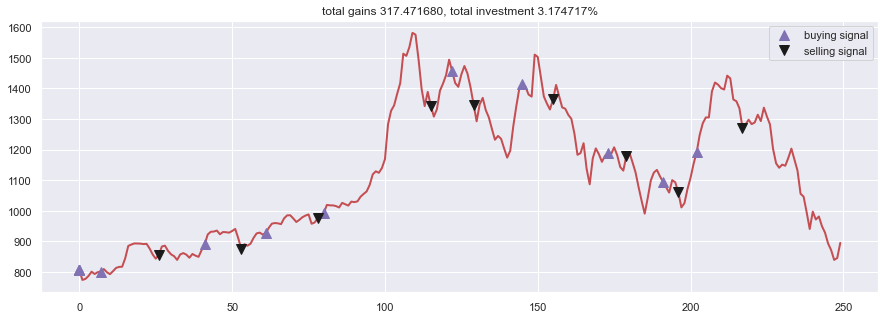

In [29]:
close =  result_forecast
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()